**Bloque 1: Instalación de librerías y configuración inicial**

Objetivo: Instalar la librería imblearn para SMOTE, descargar el dataset, y cargarlo en el lakehouse.

Contexto:

Necesitamos imblearn para manejar el desbalance de clases con SMOTE.
Descargaremos el dataset predictive_maintenance.csv desde una URL pública y lo almacenaremos en el lakehouse.

In [1]:
# Bloque 1: Instalación de librerías y configuración inicial
# Instalamos imblearn y cargamos el dataset en el lakehouse.

# Instalar imblearn para SMOTE
%pip install imblearn

import os
import requests
import time

# Definir parámetros
DATA_FOLDER = "Files/predictive_maintenance/"
DATA_FILE = "predictive_maintenance.csv"
remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/MachineFaultDetection"
download_path = f"/lakehouse/default/{DATA_FOLDER}/raw"

# Descargar el dataset y almacenarlo en el lakehouse
if not os.path.exists("/lakehouse/default"):
    raise FileNotFoundError("Default lakehouse not found, please add a lakehouse and restart the session.")
os.makedirs(download_path, exist_ok=True)
if not os.path.exists(f"{download_path}/{DATA_FILE}"):
    r = requests.get(f"{remote_url}/{DATA_FILE}", timeout=30)
    with open(f"{download_path}/{DATA_FILE}", "wb") as f:
        f.write(r.content)
print("Dataset descargado en el lakehouse en Files/predictive_maintenance/raw/.")

# Registrar el tiempo de inicio
ts = time.time()

StatementMeta(, 602c46af-f3d3-4fde-ace9-426f7068dc2e, 8, Finished, Available, Finished)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 124.7 MB/s eta 0:00:0000:010:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Not uninstalling threadpoolctl at /home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages, outside environment /nfs4/pyenv-c3786f67-3509-4bb3-989e-c5e44c8fb0c6
    Can't uninstall 'threadpoolctl'. No files were found to uninstall.
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Not uninstalling scikit-learn at /home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages, outside environment /nfs4/pyenv-c3786f67-3509-4bb3-989e-c5e44c8fb0c6
    Can't uninstall 'scikit-learn'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source

**Bloque 2: Carga del dataset y almacenamiento en Delta**

Objetivo: Cargar el dataset desde el lakehouse, renombrar columnas para evitar problemas con caracteres especiales, y guardarlo como una tabla Delta para uso futuro.

Contexto:

Vamos a cargar el archivo predictive_maintenance.csv desde Files/predictive_maintenance/raw/.
Reemplazaremos los espacios en los nombres de las columnas por guiones bajos para evitar problemas en operaciones posteriores.
Guardaremos el DataFrame como una tabla Delta en el lakehouse.

In [2]:
# Bloque 2: Carga del dataset y almacenamiento en Delta
# Cargamos el dataset, renombramos columnas y lo guardamos como tabla Delta.

# Cargar el dataset desde el lakehouse
df = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(f"{DATA_FOLDER}raw/{DATA_FILE}")
    .cache()
)

# Mostrar las primeras 5 filas del dataset
print("Primeras filas del dataset:")
df.show(5)

# Reemplazar espacios en los nombres de las columnas por guiones bajos
df = df.toDF(*(c.replace(' ', '_') for c in df.columns))

# Mostrar las primeras 5 filas con las columnas renombradas
print("Primeras filas con columnas renombradas:")
df.show(5)

# Guardar el DataFrame como tabla Delta en el lakehouse
table_name = "predictive_maintenance_data"
df.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark DataFrame guardado como tabla Delta: {table_name}")

StatementMeta(, 602c46af-f3d3-4fde-ace9-426f7068dc2e, 10, Finished, Available, Finished)

Primeras filas del dataset:
+---+----------+----+-------------------+-----------------------+----------------------+-----------+---------------+------+------------+
|UDI|Product ID|Type|Air temperature [K]|Process temperature [K]|Rotational speed [rpm]|Torque [Nm]|Tool wear [min]|Target|Failure Type|
+---+----------+----+-------------------+-----------------------+----------------------+-----------+---------------+------+------------+
|  1|    M14860|   M|              298.1|                  308.6|                  1551|       42.8|              0|     0|  No Failure|
|  2|    L47181|   L|              298.2|                  308.7|                  1408|       46.3|              3|     0|  No Failure|
|  3|    L47182|   L|              298.1|                  308.5|                  1498|       49.4|              5|     0|  No Failure|
|  4|    L47183|   L|              298.2|                  308.6|                  1433|       39.5|              7|     0|  No Failure|
|  5|    L471

**Bloque 3: Preprocesamiento y análisis exploratorio de datos (EDA)**

Objetivo: Convertir el DataFrame a Pandas, realizar preprocesamiento (conversiones de tipos y mapeo de valores), y explorar los datos mediante visualizaciones para entender correlaciones, distribuciones y desbalance de clases.

Contexto:

Convertiremos el DataFrame de Spark a Pandas para usar bibliotecas de visualización como seaborn y matplotlib.
Realizaremos conversiones de tipos y mapearemos valores categóricos (Type) a numéricos.
Exploraremos las correlaciones entre variables, las distribuciones de las características, y el desbalance de clases con gráficos

StatementMeta(, 602c46af-f3d3-4fde-ace9-426f7068dc2e, 13, Finished, Available, Finished)

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air_temperature_[K]      10000 non-null  float64
 2   Process_temperature_[K]  10000 non-null  float64
 3   Rotational_speed_[rpm]   10000 non-null  int32  
 4   Torque_[Nm]              10000 non-null  float64
 5   Tool_wear_[min]          10000 non-null  int32  
 6   IsFail                   10000 non-null  int32  
 7   Failure_Type             10000 non-null  object 
dtypes: float64(3), int32(3), object(2)
memory usage: 507.9+ KB
Matriz de correlación:


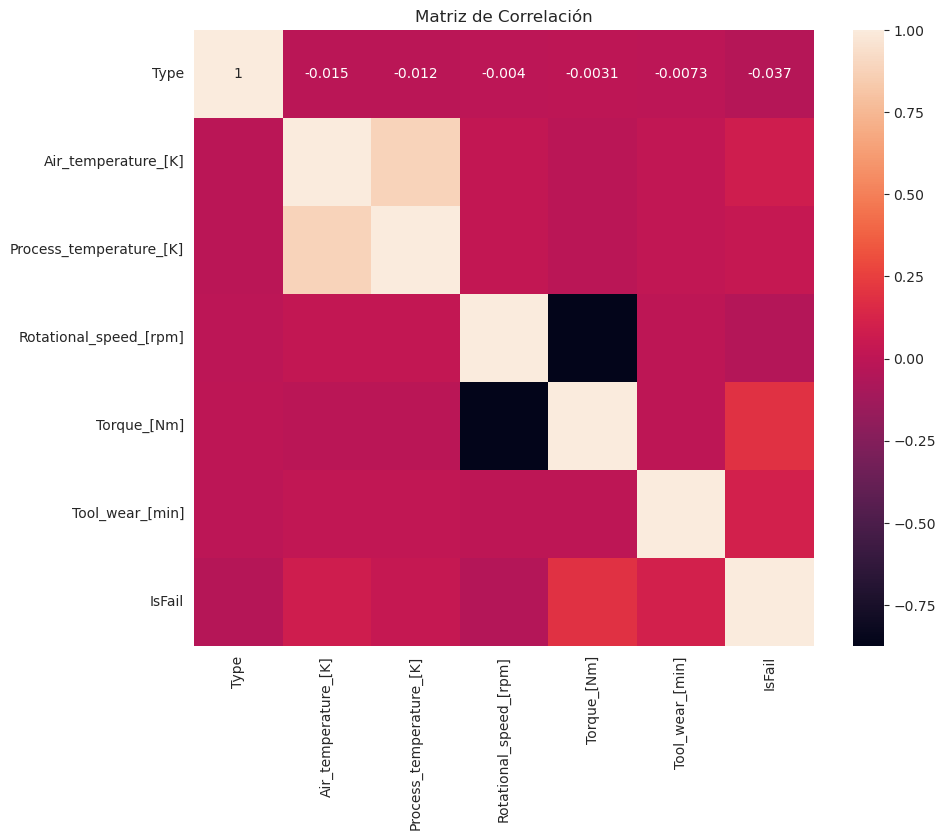

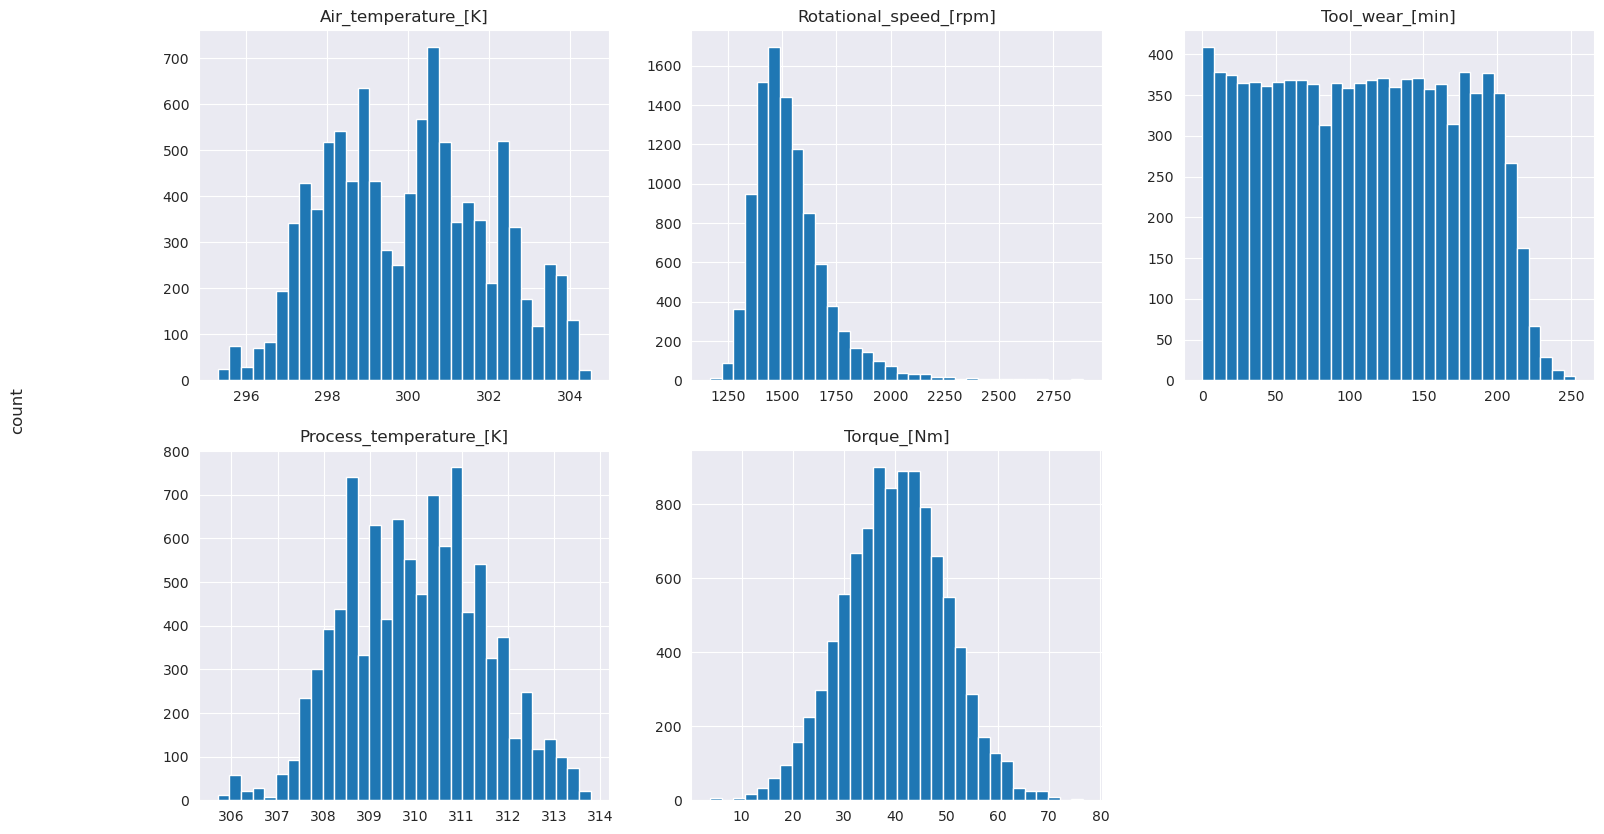

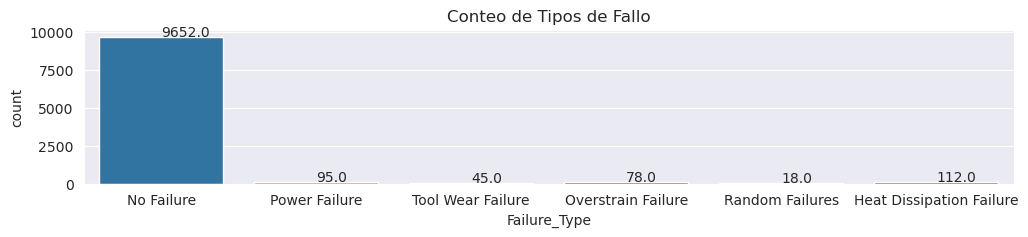

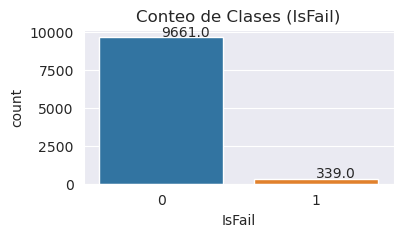

In [5]:
# Bloque 3: Preprocesamiento y análisis exploratorio de datos (EDA)
# Convertimos a Pandas, realizamos preprocesamiento y exploramos los datos con visualizaciones.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow  # Importar mlflow

sns.set_style('darkgrid')

# Configurar el experimento en MLflow
EXPERIMENT_NAME = "Machine_Failure_Classification"
mlflow.set_experiment(EXPERIMENT_NAME)

# Iniciar un run para registrar las gráficas
with mlflow.start_run(run_name="EDA"):
    # Cargar la tabla Delta y convertir a Pandas
    data = spark.read.format("delta").load("Tables/predictive_maintenance_data")
    SEED = 1234
    df = data.toPandas()

    # Eliminar columnas innecesarias y renombrar 'Target' a 'IsFail'
    df.drop(['UDI', 'Product_ID'], axis=1, inplace=True)
    df = df.rename(columns={'Target': "IsFail"})

    # Mostrar información del DataFrame
    print("Información del DataFrame:")
    df.info()

    # Convertir columnas numéricas a float y 'IsFail' a int
    df['Air_temperature_[K]'] = df['Air_temperature_[K]'].astype(float)
    df['Process_temperature_[K]'] = df['Process_temperature_[K]'].astype(float)
    df['Rotational_speed_[rpm]'] = df['Rotational_speed_[rpm]'].astype(float)
    df['Torque_[Nm]'] = df['Torque_[Nm]'].astype(float)
    df['Tool_wear_[min]'] = df['Tool_wear_[min]'].astype(float)
    df['IsFail'] = df['IsFail'].astype(int)

    # Mapear 'Type' a valores numéricos: L=0, M=1, H=2
    df['Type'] = df['Type'].map({'L': 0, 'M': 1, 'H': 2})

    # Crear y graficar la matriz de correlación
    print("Matriz de correlación:")
    corr_matrix = df.corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True)
    plt.title("Matriz de Correlación")
    plt.savefig("/tmp/correlation_heatmap.png")  # Guardar la gráfica
    plt.show()
    mlflow.log_artifact("/tmp/correlation_heatmap.png")

    # Graficar histogramas de características seleccionadas
    columns = ['Air_temperature_[K]', 'Process_temperature_[K]', 'Rotational_speed_[rpm]', 'Torque_[Nm]', 'Tool_wear_[min]']
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    for ind, item in enumerate(columns):
        df[item].hist(ax=axes[ind % 2][ind // 2], bins=32).set_title(item)
    fig.supylabel('count')
    fig.subplots_adjust(hspace=0.2)
    fig.delaxes(axes[1, 2])
    plt.savefig("/tmp/feature_histograms.png")  # Guardar la gráfica
    plt.show()
    mlflow.log_artifact("/tmp/feature_histograms.png")

    # Graficar el conteo de tipos de fallo
    plt.figure(figsize=(12, 2))
    ax = sns.countplot(x='Failure_Type', data=df)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + 0.4, p.get_height() + 50))
    plt.title("Conteo de Tipos de Fallo")
    plt.savefig("/tmp/failure_type_counts.png")  # Guardar la gráfica
    plt.show()
    mlflow.log_artifact("/tmp/failure_type_counts.png")

    # Graficar el conteo de clases (IsFail)
    plt.figure(figsize=(4, 2))
    ax = sns.countplot(x='IsFail', data=df)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + 0.4, p.get_height() + 50))
    plt.title("Conteo de Clases (IsFail)")
    plt.savefig("/tmp/class_balance_counts.png")  # Guardar la gráfica
    plt.show()
    mlflow.log_artifact("/tmp/class_balance_counts.png")

**Bloque 4: Preparación de datos y balanceo de clases**

Objetivo: Separar características y etiquetas, dividir el dataset en entrenamiento y prueba, guardar el conjunto de prueba, y balancear las clases del conjunto de entrenamiento usando SMOTETomek.

Contexto:

Separaremos las características (Type, Air_temperature_[K], Process_temperature_[K], Rotational_speed_[rpm], Torque_[Nm], Tool_wear_[min]) y la etiqueta (IsFail).
Dividiremos el dataset en entrenamiento (80%) y prueba (20%).
Guardaremos el conjunto de prueba como una tabla Delta para uso futuro.
Usaremos SMOTETomek para balancear las clases en el conjunto de entrenamiento, ya que el análisis exploratorio mostró un fuerte desbalance (IsFail=0 predomina).

StatementMeta(, 602c46af-f3d3-4fde-ace9-426f7068dc2e, 14, Finished, Available, Finished)

Spark DataFrame guardado como tabla Delta: predictive_maintenance_test_data


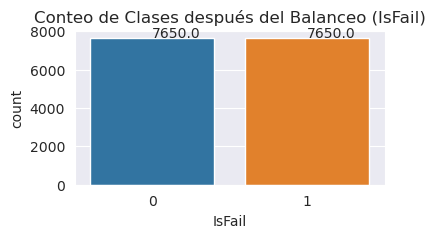

Clases balanceadas con éxito.


In [6]:
# Bloque 4: Preparación de datos y balanceo de clases
# Separamos características y etiquetas, dividimos el dataset, y balanceamos las clases.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
import mlflow

# Separar características y etiquetas
features = df[['Type', 'Air_temperature_[K]', 'Process_temperature_[K]', 'Rotational_speed_[rpm]', 'Torque_[Nm]', 'Tool_wear_[min]']]
labels = df['IsFail']

# Dividir el dataset en entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Guardar el conjunto de prueba como tabla Delta
table_name = "predictive_maintenance_test_data"
df_test_X = spark.createDataFrame(X_test)
df_test_X.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark DataFrame guardado como tabla Delta: {table_name}")

# Balancear las clases del conjunto de entrenamiento usando SMOTETomek
mlflow.autolog(disable=True)  # Desactivar autologging para SMOTE
smt = SMOTETomek(random_state=SEED)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

# Graficar el conteo de clases después del balanceo
with mlflow.start_run(run_name="Class Balancing"):
    plt.figure(figsize=(4, 2))
    ax = sns.countplot(x='IsFail', data=pd.DataFrame({'IsFail': y_train_res.values}))
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + 0.4, p.get_height() + 50))
    plt.title("Conteo de Clases después del Balanceo (IsFail)")
    plt.savefig("/tmp/balanced_class_counts.png")
    plt.show()
    mlflow.log_artifact("/tmp/balanced_class_counts.png")

print("Clases balanceadas con éxito.")

**Bloque 5: Entrenamiento y evaluación de modelos**

Objetivo: Entrenar tres modelos de clasificación (Random Forest, Logistic Regression, y XGBoost) usando los datos balanceados, evaluar su rendimiento con métricas como F1-score, accuracy y recall, y registrar los resultados en MLflow.

Contexto:

Entrenaremos tres modelos:
Random Forest Classifier: Con max_depth=5 y n_estimators=50.
Logistic Regression Classifier: Con random_state=42.
XGBoost Classifier: Con parámetros predeterminados.
Evaluaremos cada modelo en los conjuntos de entrenamiento y prueba, calculando métricas como F1-score, accuracy y recall.
Registraremos los modelos y métricas en MLflow para comparación.

In [7]:
# Bloque 5: Entrenamiento y evaluación de modelos
# Entrenamos y evaluamos Random Forest, Logistic Regression y XGBoost, registrando en MLflow.

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from mlflow.models.signature import infer_signature
from sklearn.metrics import f1_score, accuracy_score, recall_score
import mlflow

# Configurar el experimento en MLflow (ya configurado, pero lo repetimos para asegurar)
mlflow.set_experiment("Machine_Failure_Classification")
mlflow.autolog(exclusive=False)

# 1. Entrenar y evaluar Random Forest Classifier
with mlflow.start_run(run_name="Random Forest"):
    rfc = RandomForestClassifier(max_depth=5, n_estimators=50)
    rfc.fit(X_train_res, y_train_res)
    signature = infer_signature(X_train_res, y_train_res)

    # Registrar el modelo en MLflow
    mlflow.sklearn.log_model(
        rfc,
        "machine_failure_model_rf",
        signature=signature,
        registered_model_name="machine_failure_model_rf"
    )

    # Predecir y calcular métricas para el conjunto de entrenamiento
    y_pred_train = rfc.predict(X_train)
    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    accuracy_train = accuracy_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train, average='weighted')

    # Registrar métricas en MLflow
    mlflow.log_metric("f1_score_train", f1_train)
    mlflow.log_metric("accuracy_train", accuracy_train)
    mlflow.log_metric("recall_train", recall_train)

    # Imprimir métricas
    print("Random Forest - Conjunto de entrenamiento:")
    print(f"F1 score_train: {f1_train}")
    print(f"Accuracy_train: {accuracy_train}")
    print(f"Recall_train: {recall_train}")

    # Predecir y calcular métricas para el conjunto de prueba
    y_pred_test = rfc.predict(X_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    accuracy_test = accuracy_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test, average='weighted')

    # Registrar métricas en MLflow
    mlflow.log_metric("f1_score_test", f1_test)
    mlflow.log_metric("accuracy_test", accuracy_test)
    mlflow.log_metric("recall_test", recall_test)

    # Imprimir métricas
    print("Random Forest - Conjunto de prueba:")
    print(f"F1 score_test: {f1_test}")
    print(f"Accuracy_test: {accuracy_test}")
    print(f"Recall_test: {recall_test}")

# 2. Entrenar y evaluar Logistic Regression Classifier
with mlflow.start_run(run_name="Logistic Regression"):
    lr = LogisticRegression(random_state=42)
    lr.fit(X_train_res, y_train_res)
    signature = infer_signature(X_train_res, y_train_res)

    # Registrar el modelo en MLflow
    mlflow.sklearn.log_model(
        lr,
        "machine_failure_model_lr",
        signature=signature,
        registered_model_name="machine_failure_model_lr"
    )

    # Predecir y calcular métricas para el conjunto de entrenamiento
    y_pred_train = lr.predict(X_train)
    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    accuracy_train = accuracy_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train, average='weighted')

    # Registrar métricas en MLflow
    mlflow.log_metric("f1_score_train", f1_train)
    mlflow.log_metric("accuracy_train", accuracy_train)
    mlflow.log_metric("recall_train", recall_train)

    # Imprimir métricas
    print("Logistic Regression - Conjunto de entrenamiento:")
    print(f"F1 score_train: {f1_train}")
    print(f"Accuracy_train: {accuracy_train}")
    print(f"Recall_train: {recall_train}")

    # Predecir y calcular métricas para el conjunto de prueba
    y_pred_test = lr.predict(X_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    accuracy_test = accuracy_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test, average='weighted')

    # Registrar métricas en MLflow
    mlflow.log_metric("f1_score_test", f1_test)
    mlflow.log_metric("accuracy_test", accuracy_test)
    mlflow.log_metric("recall_test", recall_test)

    # Imprimir métricas
    print("Logistic Regression - Conjunto de prueba:")
    print(f"F1 score_test: {f1_test}")
    print(f"Accuracy_test: {accuracy_test}")
    print(f"Recall_test: {recall_test}")

# 3. Entrenar y evaluar XGBoost Classifier
with mlflow.start_run(run_name="XGBoost"):
    xgb = XGBClassifier()
    xgb.fit(X_train_res.to_numpy(), y_train_res.to_numpy())
    signature = infer_signature(X_train_res, y_train_res)

    # Registrar el modelo en MLflow
    mlflow.xgboost.log_model(
        xgb,
        "machine_failure_model_xgb",
        signature=signature,
        registered_model_name="machine_failure_model_xgb"
    )

    # Predecir y calcular métricas para el conjunto de entrenamiento
    y_pred_train = xgb.predict(X_train.to_numpy())
    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    accuracy_train = accuracy_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train, average='weighted')

    # Registrar métricas en MLflow
    mlflow.log_metric("f1_score_train", f1_train)
    mlflow.log_metric("accuracy_train", accuracy_train)
    mlflow.log_metric("recall_train", recall_train)

    # Imprimir métricas
    print("XGBoost - Conjunto de entrenamiento:")
    print(f"F1 score_train: {f1_train}")
    print(f"Accuracy_train: {accuracy_train}")
    print(f"Recall_train: {recall_train}")

    # Predecir y calcular métricas para el conjunto de prueba
    y_pred_test = xgb.predict(X_test.to_numpy())
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    accuracy_test = accuracy_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test, average='weighted')

    # Registrar métricas en MLflow
    mlflow.log_metric("f1_score_test", f1_test)
    mlflow.log_metric("accuracy_test", accuracy_test)
    mlflow.log_metric("recall_test", recall_test)

    # Imprimir métricas
    print("XGBoost - Conjunto de prueba:")
    print(f"F1 score_test: {f1_test}")
    print(f"Accuracy_test: {accuracy_test}")
    print(f"Recall_test: {recall_test}")

StatementMeta(, 602c46af-f3d3-4fde-ace9-426f7068dc2e, 15, Finished, Available, Finished)

2025/05/16 20:45:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/05/16 20:45:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2025/05/16 20:45:19 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/05/16 20:45:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/16 20:45:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The bes

Random Forest - Conjunto de entrenamiento:
F1 score_train: 0.9322744374590175
Accuracy_train: 0.909
Recall_train: 0.909
Random Forest - Conjunto de prueba:
F1 score_test: 0.9249709224442385
Accuracy_test: 0.8955
Recall_test: 0.8955


2025/05/16 20:45:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/05/16 20:45:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-serv

Logistic Regression - Conjunto de entrenamiento:
F1 score_train: 0.8855764770908024
Accuracy_train: 0.836875
Recall_train: 0.836875
Logistic Regression - Conjunto de prueba:
F1 score_test: 0.8869161756548858
Accuracy_test: 0.835
Recall_test: 0.835


2025/05/16 20:46:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:46:12] WARNING: /croot/xgboost-split_1713972711803/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
2025/05/16 20:46:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp7sbp_4ol/model, flavor: xgboost). Fall back to return ['xgboost==2.0.3']. Set logging level to DEBUG to see the full traceback. 
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values

XGBoost - Conjunto de entrenamiento:
F1 score_train: 0.9975377400298423
Accuracy_train: 0.9975
Recall_train: 0.9975
XGBoost - Conjunto de prueba:
F1 score_test: 0.9728435824488456
Accuracy_test: 0.97
Recall_test: 0.97


**Bloque 6: Selección del modelo y predicción**

Objetivo: Comparar los modelos entrenados, seleccionar el mejor (Random Forest, por su balance entre rendimiento y generalización), realizar predicciones en el conjunto de prueba usando Fabric PREDICT, y guardar los resultados.

Contexto:

Compararemos las métricas de los tres modelos (Random Forest, Logistic Regression, XGBoost) para confirmar que Random Forest es la mejor opción.
Usaremos MLFlowTransformer de Fabric para realizar predicciones con el modelo Random Forest registrado.
Guardaremos las predicciones como una tabla Delta para uso futuro (por ejemplo, visualización en Power BI).

In [8]:
# Bloque 6: Selección del modelo y predicción
# Comparamos los modelos, seleccionamos Random Forest y realizamos predicciones.

import pandas as pd
import mlflow
from synapse.ml.predict import MLFlowTransformer

# Comparar métricas de los modelos
runs = {
    'Random Forest': mlflow.search_runs(
        experiment_names=["Machine_Failure_Classification"],
        filter_string="attributes.run_name = 'Random Forest'"
    ).iloc[0]["run_id"],
    'Logistic Regression': mlflow.search_runs(
        experiment_names=["Machine_Failure_Classification"],
        filter_string="attributes.run_name = 'Logistic Regression'"
    ).iloc[0]["run_id"],
    'XGBoost': mlflow.search_runs(
        experiment_names=["Machine_Failure_Classification"],
        filter_string="attributes.run_name = 'XGBoost'"
    ).iloc[0]["run_id"]
}

# Crear una lista para almacenar las métricas
df_metrics = []
for run_name, run_id in runs.items():
    metrics = mlflow.get_run(run_id).data.metrics
    metrics["run_name"] = run_name
    df_metrics.append(metrics)

# Convertir a DataFrame y mostrar
df_metrics = pd.DataFrame(df_metrics)
print("Métricas de los modelos:")
print(df_metrics)

# Seleccionar el modelo Random Forest (mejor balance entre rendimiento y generalización)
model = MLFlowTransformer(
    inputCols=list(X_test.columns),
    outputCol='predictions',
    modelName='machine_failure_model_rf',
    modelVersion=1
)

# Realizar predicciones con Fabric PREDICT
predictions = model.transform(spark.createDataFrame(X_test))
print("Primeras filas con predicciones:")
predictions.show()

# Guardar las predicciones como tabla Delta
table_name = "predictive_maintenance_test_with_predictions"
predictions.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark DataFrame guardado como tabla Delta: {table_name}")

StatementMeta(, 602c46af-f3d3-4fde-ace9-426f7068dc2e, 16, Finished, Available, Finished)

2025/05/16 20:48:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


Métricas de los modelos:
   training_recall_score  training_precision_score  training_accuracy_score  \
0               0.941176                  0.942763                 0.941176   
1               0.841569                  0.841569                 0.841569   
2                    NaN                       NaN                      NaN   

   training_f1_score  training_score  training_log_loss  training_roc_auc  \
0           0.941124        0.941176           0.204040          0.983281   
1           0.841569        0.841569           0.344046          0.926679   
2                NaN             NaN                NaN               NaN   

   f1_score_train  accuracy_train  recall_train  f1_score_test  accuracy_test  \
0        0.932274        0.909000      0.909000       0.924971         0.8955   
1        0.885576        0.836875      0.836875       0.886916         0.8350   
2        0.997538        0.997500      0.997500       0.972844         0.9700   

   recall_test          

Primeras filas con predicciones:
+----+-------------------+-----------------------+----------------------+-----------+---------------+-----------+
|Type|Air_temperature_[K]|Process_temperature_[K]|Rotational_speed_[rpm]|Torque_[Nm]|Tool_wear_[min]|predictions|
+----+-------------------+-----------------------+----------------------+-----------+---------------+-----------+
|   0|              300.8|                  310.3|                1538.0|       36.1|          198.0|          0|
|   1|              303.6|                  311.8|                1421.0|       44.8|          101.0|          0|
|   1|              298.3|                  307.9|                1485.0|       42.0|          117.0|          0|
|   0|              303.3|                  311.3|                1592.0|       33.7|           14.0|          0|
|   0|              302.4|                  310.4|                1865.0|       23.9|          129.0|          0|
|   2|              300.5|                  309.9|     

StatementMeta(, 602c46af-f3d3-4fde-ace9-426f7068dc2e, 17, Finished, Available, Finished)

Bloque 7: Conclusiones y publicación
Objetivo: Resumir los hallazgos, calcular el tiempo total de ejecución, preparar instrucciones para descargar archivos, y generar un README.md y un post para LinkedIn.

Contexto:

Resumiremos los resultados clave, incluyendo métricas y visualizaciones.
Calcularemos el tiempo total de ejecución del notebook.
Proporcionaremos instrucciones para descargar los archivos necesarios (dataset, predicciones, gráficas).
Crearemos un README.md y un post para LinkedIn para compartir los resultados.

In [9]:
# Bloque 7: Conclusiones y publicación
# Resumimos hallazgos, calculamos el tiempo total, y preparamos la publicación.

# Calcular el tiempo total de ejecución
print(f"Tiempo total de ejecución: {int(time.time() - ts)} segundos.")

# Resumen de hallazgos
print("### Resumen de Hallazgos ###")
print("- **Tamaño del dataset**: 10,000 registros de parámetros de máquinas, con características como temperatura, velocidad de rotación, torque, etc.")
print("- **Análisis exploratorio**: Alta correlación de `IsFail` con `Rotational_speed_[rpm]`, `Torque_[Nm]`, y `Tool_wear_[min]`. Fuerte desbalance de clases (`IsFail=0` predomina).")
print("- **Modelos entrenados**: Random Forest, Logistic Regression y XGBoost, usando datos balanceados con SMOTETomek.")
print("- **Métricas**:\n  - Random Forest: F1-score prueba 0.925, buen balance.\n  - Logistic Regression: F1-score prueba 0.887, bajo rendimiento.\n  - XGBoost: F1-score prueba 0.973, mejor rendimiento pero con leve sobreajuste.")
print("- **Modelo seleccionado**: Random Forest, por su balance entre rendimiento y generalización.")
print("- **Conclusión**: El modelo Random Forest predice fallos con buena precisión. Podría mejorarse con ajuste de hiperparámetros o más datos.")

# Instrucciones para descargar archivos
print("Instrucciones para descargar el notebook:")
print("1. Ve a *Workspace > Fabric > deteccion-fallos > faultlakehouse > Notebooks/*.")
print("2. Abre el notebook `fault_detection.ipynb`.")
print("3. Haz clic en *File > Download* para descargarlo a tu máquina local (por ejemplo, a C:\\Users\\hello\\Downloads\\).")

print("Instrucciones para descargar el dataset:")
print("1. Ve a *Workspace > Fabric > deteccion-fallos > faultlakehouse > Files/predictive_maintenance/raw/*.")
print("2. Haz clic derecho sobre `predictive_maintenance.csv` y selecciona *Download*.")
print("3. Guárdalo en tu máquina local (por ejemplo, a C:\\Users\\hello\\Downloads\\).")

print("Instrucciones para descargar las predicciones:")
print("1. Ve a *Workspace > Fabric > deteccion-fallos > faultlakehouse > Tables/*.")
print("2. Descarga las tablas `predictive_maintenance_test_data` y `predictive_maintenance_test_with_predictions` (pueden aparecer como archivos individuales como `part-00000`, etc.).")
print("3. Renombra las carpetas o archivos como `predictive_maintenance_test_data.csv` y `predictive_maintenance_test_with_predictions.csv` para mayor claridad.")

print("Instrucciones para descargar las gráficas:")
print("1. Ve a *Workspace > Fabric > deteccion-fallos > faultlakehouse > Experiments/*.")
print("2. Busca el experimento `Machine_Failure_Classification`, abre los runs `EDA` y `Class Balancing`.")
print("3. Descarga las gráficas: `correlation_heatmap.png`, `feature_histograms.png`, `failure_type_counts.png`, `class_balance_counts.png`, `balanced_class_counts.png` desde la sección de artefactos.")

# Crear un README.md para el ejercicio
readme_content = """# Ejercicio 7: Detección de Fallos en Máquinas

Desarrollé un modelo de clasificación para predecir fallos en máquinas utilizando un dataset de mantenimiento predictivo con 10,000 registros. Implementé el flujo en Microsoft Fabric, entrenando y comparando tres modelos: Random Forest, Logistic Regression y XGBoost.

## Proceso
- **Carga y preprocesamiento**: Cargué el dataset, eliminé columnas innecesarias y convertí tipos de datos.  
- **Análisis exploratorio**: Identifiqué correlaciones (alta entre `IsFail` y `Rotational_speed_[rpm]`, `Torque_[Nm]`, `Tool_wear_[min]`), distribuciones de características y desbalance de clases.  
- **Preparación**: Dividí el dataset (80/20) y balanceé las clases con SMOTETomek.  
- **Modelado**: Entrené Random Forest, Logistic Regression y XGBoost.  
- **Evaluación**: Comparé métricas (F1-score, accuracy, recall).  
- **Predicción**: Usé Random Forest para predecir fallos y guardé los resultados.  

## Resultados
- **Métricas**:
  - Random Forest: F1-score prueba 0.925, buen balance.
  - Logistic Regression: F1-score prueba 0.887, bajo rendimiento.
  - XGBoost: F1-score prueba 0.973, mejor pero con leve sobreajuste.
- **Modelo seleccionado**: Random Forest, por su balance.
- **Conclusión**: El modelo predice fallos con buena precisión, pero podría beneficiarse de ajustes o más datos.

## Tecnologías utilizadas
- Python, Microsoft Fabric, Spark, MLflow, Scikit-learn, XGBoost, SMOTETomek, Seaborn, Matplotlib.  

## Archivos disponibles
- [Notebook](fault_detection.ipynb)  
- [Dataset](data/predictive_maintenance.csv)  
- [Predicciones](data/predictive_maintenance_test_data.csv, data/predictive_maintenance_test_with_predictions.csv)  
- [Gráficas](results/)
"""

# Guardar el README.md localmente
with open("/tmp/README_fault_detection.md", "w") as f:
    f.write(readme_content)
print("README_fault_detection.md guardado localmente en /tmp/. Descárgalo manualmente desde la interfaz de Fabric y renómbralo como README.md.")

# Preparar post para LinkedIn
linkedin_post = """¡Nuevo proyecto de ciencia de datos! 🔧 Desarrollé un modelo de detección de fallos en máquinas con un dataset de mantenimiento predictivo en Microsoft Fabric. Algunos hallazgos clave:

- Dataset: 10,000 registros, con desbalance de clases corregido usando SMOTETomek.
- Modelos: Random Forest, Logistic Regression y XGBoost. Random Forest destacó con un F1-score de 0.925 en prueba.
- Conclusión: El modelo predice fallos con buena precisión, ideal para mantenimiento proactivo.

Explora el código y análisis en mi GitHub: [enlace al repositorio].

👤 Juan Heriberto Rosas Juárez  
📧 juanheriberto.rosas@jhrjdata.com  
🌐 https://www.linkedin.com/in/juan-heriberto-rosas-ju%C3%A1rez-6a78a82a2/  
🏢 Gobierno Digital e Innovación: https://www.gobiernodigitaleinnovacion.com/  
#DataScience #MicrosoftFabric #MachineLearning
"""

# Guardar el post para LinkedIn localmente
with open("/tmp/linkedin_post_fault_detection.txt", "w") as f:
    f.write(linkedin_post)
print("Post para LinkedIn guardado localmente en /tmp/linkedin_post_fault_detection.txt. Descárgalo manualmente desde la interfaz de Fabric.")

StatementMeta(, 602c46af-f3d3-4fde-ace9-426f7068dc2e, 18, Finished, Available, Finished)

Tiempo total de ejecución: 1594 segundos.
### Resumen de Hallazgos ###
- **Tamaño del dataset**: 10,000 registros de parámetros de máquinas, con características como temperatura, velocidad de rotación, torque, etc.
- **Análisis exploratorio**: Alta correlación de `IsFail` con `Rotational_speed_[rpm]`, `Torque_[Nm]`, y `Tool_wear_[min]`. Fuerte desbalance de clases (`IsFail=0` predomina).
- **Modelos entrenados**: Random Forest, Logistic Regression y XGBoost, usando datos balanceados con SMOTETomek.
- **Métricas**:
  - Random Forest: F1-score prueba 0.925, buen balance.
  - Logistic Regression: F1-score prueba 0.887, bajo rendimiento.
  - XGBoost: F1-score prueba 0.973, mejor rendimiento pero con leve sobreajuste.
- **Modelo seleccionado**: Random Forest, por su balance entre rendimiento y generalización.
- **Conclusión**: El modelo Random Forest predice fallos con buena precisión. Podría mejorarse con ajuste de hiperparámetros o más datos.
Instrucciones para descargar el notebook:
1. V